<a href="https://colab.research.google.com/github/CastroNicole/CastroN_FinalProject_IntroductionToWebDevelopment/blob/main/Augmentation_Ground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Augmentor

In [ ]:
from PIL import Image
import os

input_dir = "/content/drive/MyDrive/Special Problem/Leaves/Datasets/Diseases"

# Convert all images to RGB
for root, dirs, files in os.walk(input_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                if img.mode != 'RGB':
                    rgb_img = img.convert('RGB')
                    rgb_img.save(file_path)
                    print(f"Converted {file_path} to RGB.")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

In [ ]:
import Augmentor
p = Augmentor.Pipeline("/content/drive/MyDrive/Special Problem/Leaves/Datasets/Diseases", output_directory="/content/drive/MyDrive/Special Problem/Leaves/Outputs/output")

Initialised with 9501 image(s) found.
Output directory set to /content/drive/MyDrive/Special Problem/Leaves/Outputs/output.

In [ ]:
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

In [ ]:
p.sample(15000)

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7A9268AA5570>: 100%|██████████| 15000/15000 [03:40<00:00, 68.11 Samples/s] 


In [ ]:
import pathlib
import tensorflow as tf

data_dir = pathlib.Path('/content/drive/MyDrive/Special Problem/Leaves/Outputs/output')
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=8
)

Found 15000 files belonging to 7 classes.
Using 12000 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=8
)

Found 15000 files belonging to 7 classes.
Using 3000 files for validation.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load the ResNet50 model with pretrained weights
base_model1 = ResNet50(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Freeze the first few layers (e.g., first 50 layers)
for layer in base_model1.layers[:50]:
    layer.trainable = False

# Add custom layers on top of ResNet50
x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions1 = Dense(7, activation='softmax')(x)

# Define the final model
model1 = Model(inputs=base_model1.input, outputs=predictions1)

# Print model summary (optional)
# model1.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load DenseNet121
base_model4 = DenseNet121(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Freeze some layers
for layer in base_model4.layers[:100]:
    layer.trainable = False

# Add custom layers
x = base_model4.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions4 = Dense(7, activation='softmax')(x)

model4 = Model(inputs=base_model4.input, outputs=predictions4)

# Print model summary (optional)
# model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath = "/content/drive/MyDrive/Special Problem/Leaves/Models/model-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
model1.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
model4.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Load the VGG16 model
base_model2 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the first 10 layers
for layer in base_model2.layers[:10]:
    layer.trainable = False

# Add new layers on top of the base model
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions2 = Dense(7, activation='softmax')(x)

# Create the new model
model2 = Model(inputs=base_model2.input, outputs=predictions2)

# Checkpoint to save best model per epoch
model_filepath = "/content/drive/MyDrive/Special Problem/Leaves/Models/model-{epoch:02d}-{val_accuracy:.4f}.keras"
checkpoint = ModelCheckpoint(filepath=model_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
print("Model Input Shape:", model1.input_shape)
print("Dataset Sample Shape:", next(iter(train_ds))[0].shape)

Model Input Shape: (None, 224, 224, 3)
Dataset Sample Shape: (8, 224, 224, 3)


In [ ]:
history1=model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks=[checkpoint]
)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4570 - loss: 1.5833
Epoch 1: val_accuracy improved from -inf to 0.61033, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-01-0.6103.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 108s 31ms/step - accuracy: 0.4570 - loss: 1.5831 - val_accuracy: 0.6103 - val_loss: 1.5356
Epoch 2/5
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7123 - loss: 0.7970
Epoch 2: val_accuracy improved from 0.61033 to 0.77933, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-02-0.7793.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.7123 - loss: 0.7969 - val_accuracy: 0.7793 - val_loss: 0.6047
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8133 - loss: 0.5273
Epoch 3: val_accuracy improved from 0.77933 to 0.84567, saving model to /content/drive/MyDrive/Special Problem/Leaves/Models/model-03-0.8457.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy

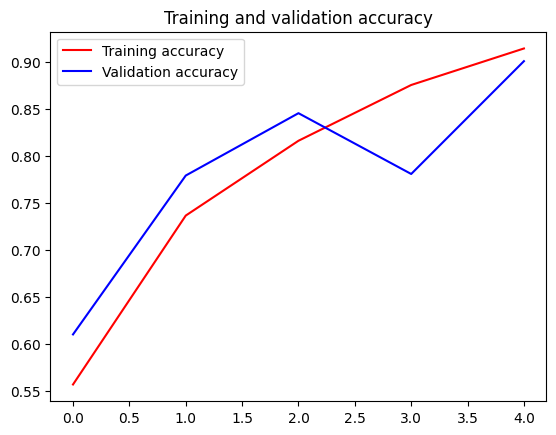

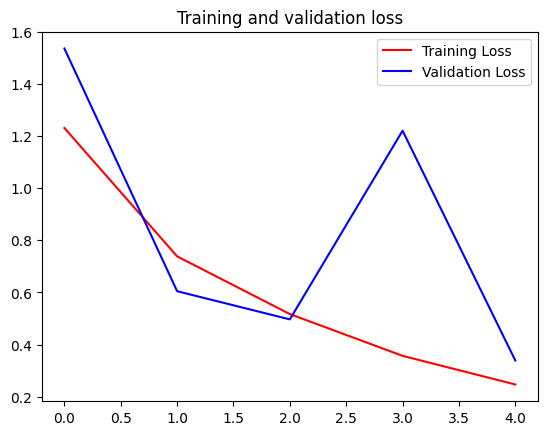

In [ ]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history4=model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  callbacks=[checkpoint]
)

Epoch 1/5
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5063 - loss: 1.3938
Epoch 1: val_accuracy did not improve from 0.90100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 186s 41ms/step - accuracy: 0.5065 - loss: 1.3935 - val_accuracy: 0.6877 - val_loss: 0.8035
Epoch 2/5
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7325 - loss: 0.7558
Epoch 2: val_accuracy did not improve from 0.90100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.7325 - loss: 0.7557 - val_accuracy: 0.7490 - val_loss: 0.7724
Epoch 3/5
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7925 - loss: 0.5871
Epoch 3: val_accuracy did not improve from 0.90100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.7925 - loss: 0.5870 - val_accuracy: 0.8293 - val_loss: 0.6057
Epoch 4/5
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8515 - loss: 0.4405
Epoch 4: val_accuracy did not improve from 0.90100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8515 - loss: 0.4405 -

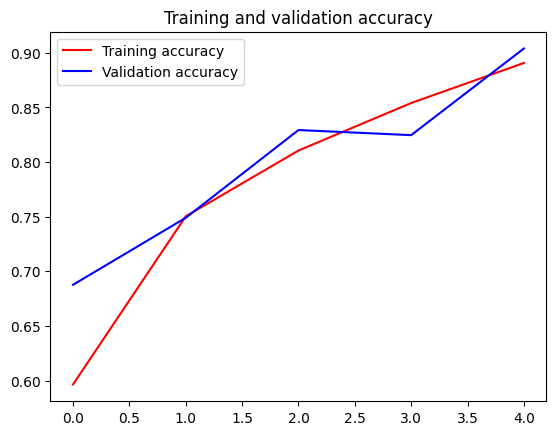

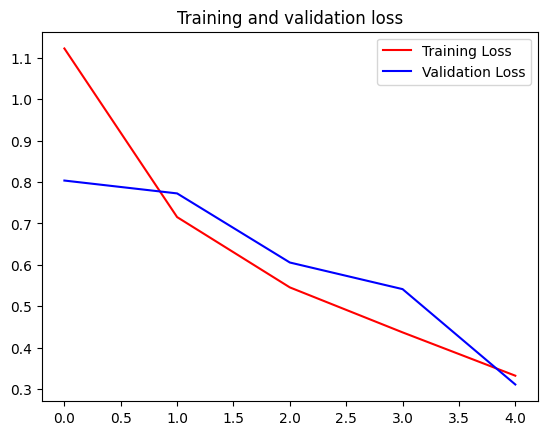

In [ ]:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/10
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2406 - loss: 1.8773
Epoch 1: val_accuracy did not improve from 0.90400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - accuracy: 0.2408 - loss: 1.8769 - val_accuracy: 0.6220 - val_loss: 1.1033 - learning_rate: 1.0000e-04
Epoch 2/10
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6114 - loss: 1.0925
Epoch 2: val_accuracy did not improve from 0.90400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.6116 - loss: 1.0920 - val_accuracy: 0.7740 - val_loss: 0.6275 - learning_rate: 1.0000e-04
Epoch 3/10
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7975 - loss: 0.5851
Epoch 3: val_accuracy did not improve from 0.90400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7976 - loss: 0.5849 - val_accuracy: 0.8480 - val_loss: 0.4577 - learning_rate: 1.0000e-04
Epoch 4/10
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8885 - loss: 0.3321
Epoch 4: val_accuracy did not improve from 0

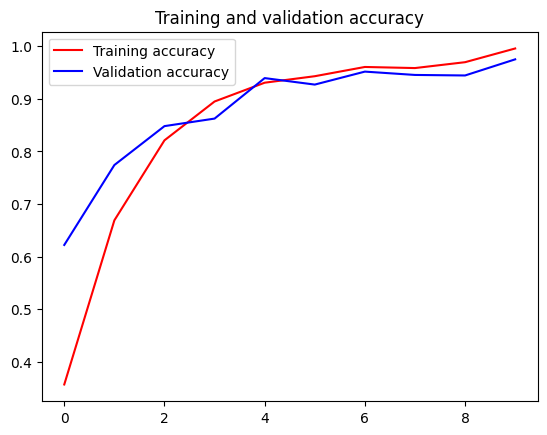

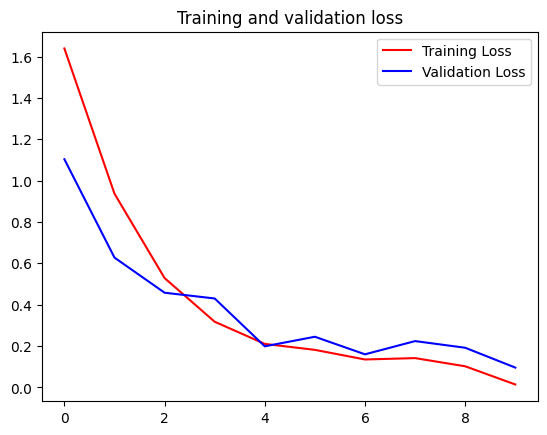

In [ ]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
  from tensorflow.keras.models import Model, load_model
  from tensorflow.keras.layers import Average, Input, Lambda
  import tensorflow as tf

  # Load models
  model_1 = load_model('/content/drive/MyDrive/Special Problem/Leaves/Models/model-05-0.9010.keras')
  model_2 = load_model('/content/drive/MyDrive/Special Problem/Leaves/Models/model-05-0.9040.keras')
  model_3 = load_model('/content/drive/MyDrive/Special Problem/Leaves/Models/model-10-0.9750.keras')

  # Input layer
  model_input = Input(shape=(224, 224, 3))

  # Wrap each model in Lambda layers to isolate their computational graphs
  output_1 = Lambda(lambda x: model_1(x), name="model_1_output")(model_input)
  output_2 = Lambda(lambda x: model_2(x), name="model_2_output")(model_input)
  output_3 = Lambda(lambda x: model_3(x), name="model_3_output")(model_input)

  # Merge outputs using Average
  ensemble_output = Average(name="ensemble_average")([output_1, output_2, output_3])

  # Create ensemble model
  ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

  # Compile ensemble model
  ensemble_model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  print("Ensemble model created successfully.")


Ensemble model created successfully.


In [ ]:
ensemble_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=ensemble_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9962 - loss: 0.0742
Epoch 1: val_accuracy did not improve from 0.97500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 40ms/step - accuracy: 0.9962 - loss: 0.0742 - val_accuracy: 0.9700 - val_loss: 0.1275
Epoch 2/10
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9963 - loss: 0.0746
Epoch 2: val_accuracy did not improve from 0.97500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.9963 - loss: 0.0746 - val_accuracy: 0.9700 - val_loss: 0.1272
Epoch 3/10
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9956 - loss: 0.0764
Epoch 3: val_accuracy did not improve from 0.97500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.9956 - loss: 0.0764 - val_accuracy: 0.9703 - val_loss: 0.1270
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9958 - loss: 0.0770
Epoch 4: val_accuracy did not improve from 0.97500
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.9958 - loss: 0.0770 - val_ac

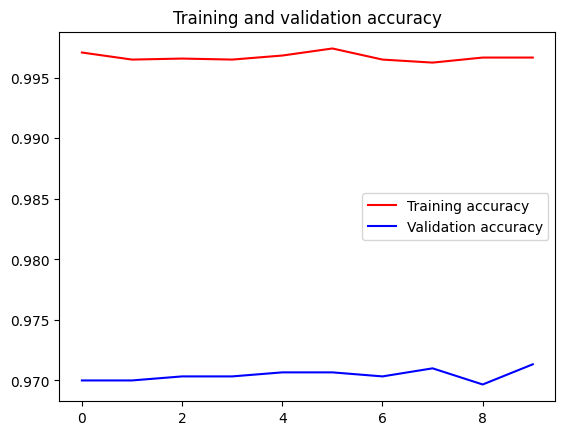

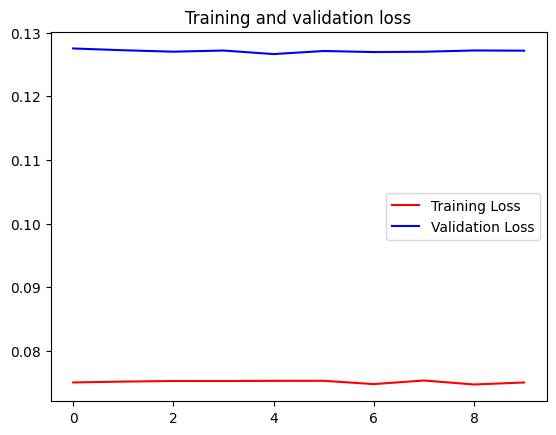

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_label = np.concatenate([y for x, y in train_ds], axis = 0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in val_ds], axis = 0)
print(test_label.shape)

(12000,)
(3000,)


375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step
Confusion Matrix
[[482   1   4   3   0   2   0]
 [  0 343   0   0   0   0   0]
 [  1   0 528   8   5   3   0]
 [  1   0   7 373   5   1   2]
 [  3   2   5   4 409   3   1]
 [  3   0   2   9   4 292   2]
 [  0   0   0   4   1   0 487]]


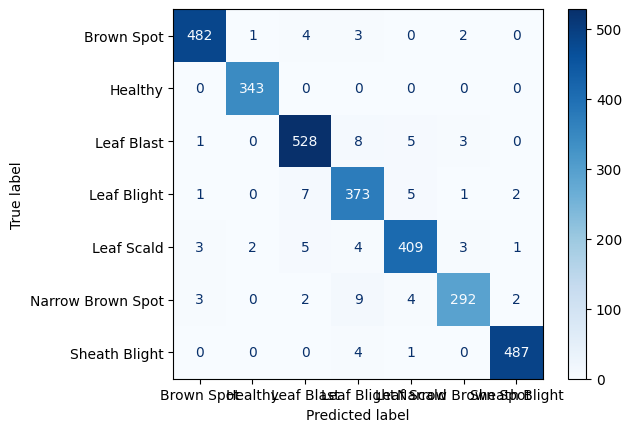

Classification Report
                   precision    recall  f1-score   support

       Brown Spot       0.98      0.98      0.98       492
          Healthy       0.99      1.00      1.00       343
       Leaf Blast       0.97      0.97      0.97       545
      Leaf Blight       0.93      0.96      0.94       389
       Leaf Scald       0.96      0.96      0.96       427
Narrow Brown Spot       0.97      0.94      0.95       312
    Sheath Blight       0.99      0.99      0.99       492

         accuracy                           0.97      3000
        macro avg       0.97      0.97      0.97      3000
     weighted avg       0.97      0.97      0.97      3000



In [ ]:
# Predict on the validation dataset
Y_pred = ensemble_model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(test_label, y_pred)
print('Confusion Matrix')
print(cm)

# Display the confusion matrix as a heatmap
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Brown Spot', 'Healthy', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print('Classification Report')
target_names = ['Brown Spot', 'Healthy', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight']
print(classification_report(test_label, y_pred, target_names=target_names))

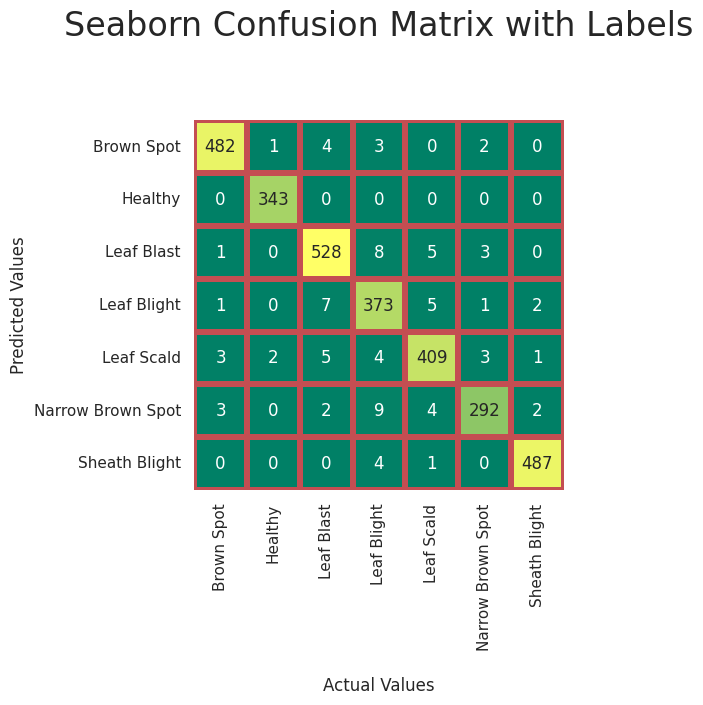

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define target names
target_names = ['Brown Spot', 'Healthy', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight']

# Plot confusion matrix using seaborn
sns.set(font_scale=1.0)
ax = sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3,
                 linecolor='r', square=True, xticklabels=target_names,
                 yticklabels=target_names, fmt='d')
sns.set(font_scale=2.0)
ax.set_title('Seaborn Confusion Matrix with Labels\n\n')
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values')

plt.show()

In [ ]:
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load trained ensemble model
@st.cache_resource
def load_ensemble_model():
    return load_model("/content/drive/MyDrive/Special Problem/Leaves/Models/ensemble_model.keras")

model = load_ensemble_model()

# Define class names
class_names = ['Brown Spot', 'Healthy', 'Leaf Blast', 'Leaf Blight', 'Leaf Scald', 'Narrow Brown Spot', 'Sheath Blight']

# Streamlit UI
st.title("Rice Leaf Disease Detection")
st.write("Upload an image of a rice leaf to classify its disease.")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    st.subheader(f"Prediction: {class_names[predicted_class]}")
    st.write(f"Confidence: {confidence:.2f}")

    # Display confidence scores
    fig, ax = plt.subplots()
    sns.barplot(x=class_names, y=predictions[0], palette="viridis", ax=ax)
    ax.set_xlabel("Disease Type")
    ax.set_ylabel("Confidence Score")
    ax.set_xticklabels(class_names, rotation=45)
    st.pyplot(fig)
